# 0: Import packages

In [ ]:
from PIL import Image, ImageFile #pip install Pillow==9.4.0
import sys
import os
import numpy as np
import logging
import glob
import subprocess
import json
import pandas as pd

from ImageCrop import ImagePreprocessor
from SpotterWrapper import Spotter, PolygonVisualizer
from IPython.display import display
from shapely.geometry import Polygon

logging.basicConfig(level=logging.INFO)
Image.MAX_IMAGE_PIXELS=None
ImageFile.LOAD_TRUNCATED_IMAGES = True


# 1: Specify filepaths

In [ ]:
# Name folders for raw data and processed data
map_data_topfolder = 'raw_maps_20231024'
map_strec_topfolder = 'processed/strec'

for fp in [map_strec_topfolder]:
    if not os.path.isdir(fp):
        os.makedirs(fp)

# IMPORTANT! Locate spotter directory and detectron weights
git_clone_location = 'C:/repo/'
spotter_directory = git_clone_location + 'mapkurator-spotter/spotter-v2'
model_weights = git_clone_location + 'detectron2-master/detectron2/checkpoint/model_v2_en.pth'
spotter_config = spotter_directory + '/configs/PALEJUN/Finetune/Rumsey_Polygon_Finetune.yaml'

# 2: Crop all jpeg maps in (user defined) map_data_topfolder

In [ ]:
def pyramid_scan(img_path, output_dir, save_each_layer=False):
    image = Image.open(img_path)
    image_preprocessor = ImagePreprocessor(image, overlapping_tolerance=0.3, num_layers=5, min_patch_resolution=512, max_patch_resolution=4096)
    image_preprocessor.process()
    print("preprocessing done")
    spotter = Spotter(spotter_config, model_weights, confidence_thresh=0.8, draw_thresh=0.85)
    all_layer_results = []

    base_image_batch, base_offset_xs, base_offset_ys = image_preprocessor.get_image_patches(0)
    vis = PolygonVisualizer()
    vis.canvas_from_patches(base_image_batch, base_offset_xs, base_offset_ys)

    for i in range(image_preprocessor.num_layers):
        # If you want to save for each layer, uncomment the following line
        # image_preprocessor.save_patches(os.path.join(output_dir, f'layer_{i}_patches'), layer=i)

        image_batch, offset_xs, offset_ys = image_preprocessor.get_image_patches(i)
        spotter.load_batch(image_batch, offset_xs, offset_ys)
        results = spotter.inference_batch()
        all_layer_results.extend(results)

        #all_layer_offset_xs.extend(offset_xs)
        #all_layer_offset_ys.extend(offset_ys)

        if save_each_layer == True:
            vis.draw(results).save(os.path.join(output_dir, f'combined_tagged_{i}.png'))
            vis.save_json(results, os.path.join(output_dir, f'combined_tagged_{i}.json'))
        else:
            pass

    vis.draw(all_layer_results).save(os.path.join(output_dir, f'combined_tagged_all_layers.png'))
    vis.save_json(all_layer_results, os.path.join(output_dir, f'combined_tagged_all_layers.json'))

# Run crop on all maps
for map_data_subfolder in next(os.walk(map_data_topfolder))[1]:
    jpeg_list = glob.glob(map_data_topfolder + '/' + map_data_subfolder + '/*.jpeg')
    if len(jpeg_list) != 1:
        print(map_data_subfolder + " failed. Please ensure there is exactly 1 file with extension .jpeg in the folder.")
    else:
        map_image = jpeg_list[0].split("\\")[1]
        if map_data_subfolder in ['1846_vandevelde', '1874_saunders', '1845_kiepert']: # '1858_vandevelde', '1874_saunders', '1845_kiepert']: #,,]: #'1858_vandevelde', '1847_tobler', '1845_kiepert'
            img_path = map_data_topfolder + '/' + map_data_subfolder + "/" + map_image
            map_name = os.path.basename(img_path).split('.')[0] # get the map name without extension
            output_dir = os.path.join(map_strec_topfolder, map_name)
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            pyramid_scan(img_path, output_dir, save_each_layer=False)
            logging.info('Done cropping %s' %img_path )

# 3: Label Combination

In [3]:
from PIL import Image, ImageFile
import json 
import pandas as pd
from collections import Counter
from shapely.geometry import Polygon, MultiPolygon
from itertools import combinations

import numpy as np
import importlib
import Clustering
import TextRectify
import TextAmalgamate
import ExtractHandling
import json
import pickle

importlib.reload(Clustering)
importlib.reload(TextRectify)
importlib.reload(TextAmalgamate)
importlib.reload(ExtractHandling)

map_name_in_strec = 'kiepert_1845'

## 3.1 Text Rectification

In [4]:
do_cluster_pre_merge = True

with open(f'processed/strec/{map_name_in_strec}/combined_tagged_all_layers.json', 'r', encoding='utf-8') as f:

    clustered = Clustering.cluster_polygons(json.load(f))

    # visualize clusters
    #image = Clustering.visualize_polygons(clustered, 'processed/strec/kiepert_1845/raw.jpeg')
    #image.save('processed/strec/kiepert_1845/combined_tagged_all_layers_clustering.png')

for label, cluster in clustered.items():
    texts = []
    scores = []
    for polygon in cluster:
        texts.append(polygon['text'])
        scores.append(polygon['score'])

    rectifier = TextRectify.TextRectifier(0.95, 0.5, 10, True, True)

    rectifier.feed_data(texts, scores)

    rectifier.fit()

    rectified, mask = rectifier.get_rectified_text()

    if rectified is None:
        rectified = max(texts, key=len)

    for i in range(len(cluster)):
        cluster[i]['text'] = rectified[i]
        cluster[i]['keep'] = mask[i]

image = Clustering.visualize_polygons(clustered, f'processed/strec/{map_name_in_strec}/raw.jpeg')
image.save(f'processed/strec/{map_name_in_strec}/combined_tagged_all_layers_rectified.png')

polygon_x = {}
polygon_y = {}
texts = {}
scores = {}
i = 0
for label, cluster in clustered.items():
    for polygon in cluster:
        if do_cluster_pre_merge:
            if polygon['keep']:
                polygon_x[str(i)] = polygon['polygon_x']
                polygon_y[str(i)] = polygon['polygon_y']
                texts[str(i)] = polygon['text']
                scores[str(i)] = polygon['score']
                i += 1
        else:
            polygon_x[str(i)] = polygon['polygon_x']
            polygon_y[str(i)] = polygon['polygon_y']
            texts[str(i)] = polygon['text']
            scores[str(i)] = polygon['score']
            i += 1

json_data = {'polygon_x': polygon_x, 'polygon_y': polygon_y, 'text': texts, 'score': scores}

with open(f'processed/strec/{map_name_in_strec}/combined_tagged_all_layers_rectified_premerge.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4)

## 3.2 Text Amalgamation

In [5]:
# Amalgamation stage - assumes there exists "combined_tagged_all_layers_rectified_premerge.json" in map_name_in_strec processed folder.
df = ExtractHandling.prepare_labels_for_amalgamation(map_name_in_strec)
df = TextAmalgamate.amalgamate_labels_wrapper(df, 0.75, .5)

# Save amalgamated labels
with open(f'processed/strec/{map_name_in_strec}/amalgamate.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

1507 labels.
1427 labels.
1402 labels.
1399 labels.
1396 labels.
1395 labels.
Amalgamation completed with 1395 labels.


## 3.3 ?

In [6]:
result = list(df["labels"])
polygons = []
texts = []
PCA_features = []

for i in range(len(result)):
    poly = result[i][0]
    polygons.append(poly)
    texts.append(result[i][1])

In [ ]:
#reload SpotterWrapper module
import importlib
import SpotterWrapper
import Grouping

importlib.reload(SpotterWrapper)
importlib.reload(Grouping)

PCA_features = Grouping.calc_PCA_feats(polygons, do_separation=True, enhance_coords=True)

print("PCA features calculated.")

vis = SpotterWrapper.PolygonVisualizer()
canvas = Image.open(f'processed/strec/{map_name_in_strec}/raw.jpeg')
vis.canvas_from_image(canvas)

vis.draw_poly(polygons, texts, PCA_features)

vis.save(f'processed/strec/{map_name_in_strec}/output.jpeg')

# 4: Evaluation

In [39]:
import Evaluation
importlib.reload(Evaluation)
%load_ext autoreload

## 4.1: Isolate crops to be used for evaluation

full map is 6528 pixels wide by 8694 pixels high.
 displaying crop:


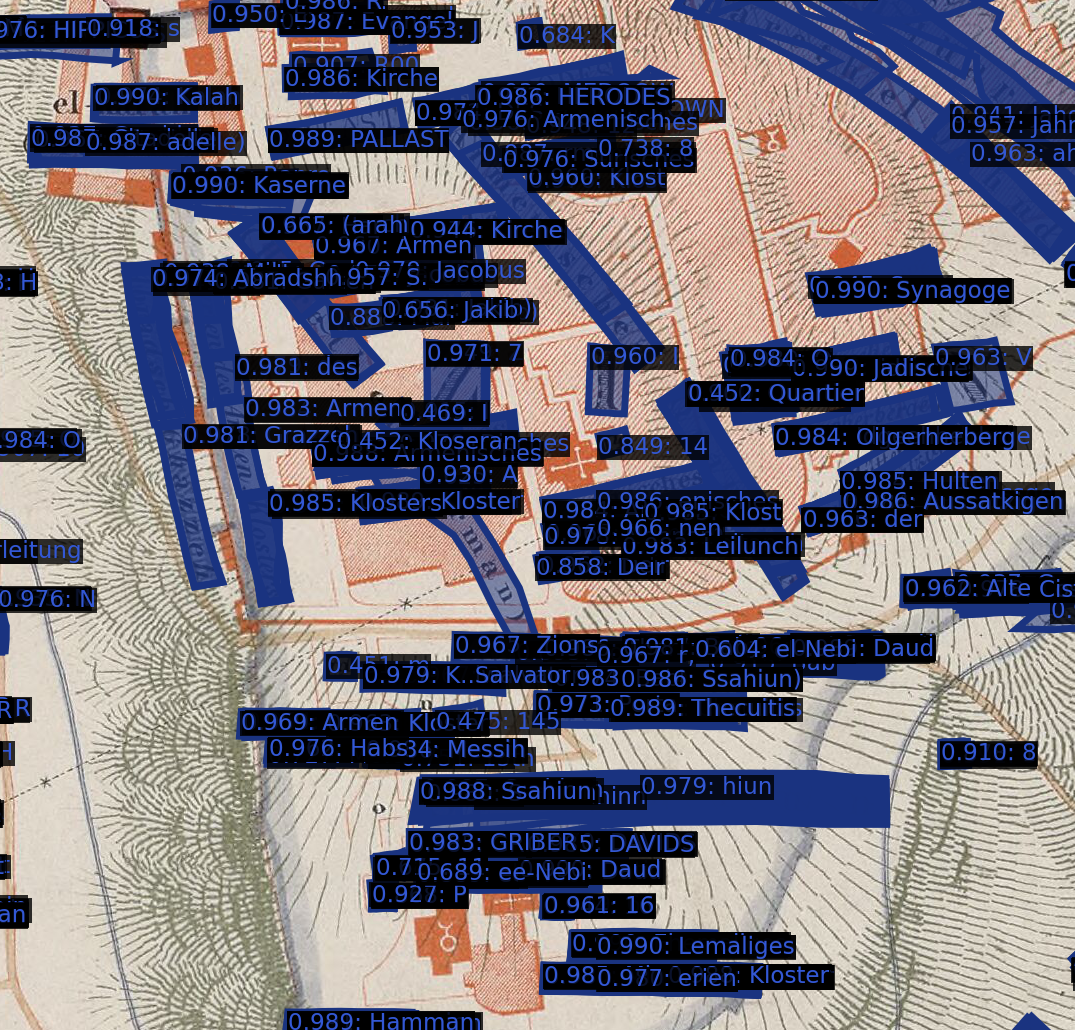

In [34]:
from PIL import Image, ImageFile
import pandas as pd
from itertools import combinations
import scipy
import numpy as np

def visualize_crop(map_name_in_strec, raw_or_spotter, left_x, right_x, top_y, bottom_y):
    if raw_or_spotter == "raw":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/raw.jpeg') 
    elif raw_or_spotter == "spotter_0":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_0.png')
    elif raw_or_spotter == "spotter_1":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_1.png')
    elif raw_or_spotter == "spotter_2":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_2.png')
    elif raw_or_spotter == "all":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_all_layers.png')
    elif raw_or_spotter == "rectified":
        map_img = Image.open('processed/strec/' + map_name_in_strec + '/combined_tagged_all_layers_rectified.png')
    width, height = map_img.size
    print("full map is " + str(width) + " pixels wide by " + str(height) + " pixels high.\n displaying crop:")
    display(map_img.crop((left_x, top_y, right_x, bottom_y, )))

left_x = 2475
right_x = 3550
top_y = 4820
bottom_y = 5850

visualize_crop("kiepert_1845", "all", left_x, right_x, top_y, bottom_y)

In [35]:
kiepert_gt_patch_1 = [2475, 3550, 4820, 5850]
saunders_gt_patch_1 = [3150, 4150, 2250, 3250]
saunders_gt_patch_2 = [6750, 7750, 2250, 3250]
saunders_gt_patch_3 = [5400, 6400, 4500, 5500]
saunders_gt_patch_4 = [7650, 8650, 5400, 6400]
saunders_gt_patch_5 = [7650, 8650, 3150, 4150]

## 4.2 Precision and Recall: IoU after 1:1 Matching

In [40]:
pyramid_detected_kiepert, num_gt_kiepert, pyramid_IoU_pairs_kiepert = Evaluation.geographic_evaluation("kiepert_1845", "components", kiepert_gt_patch_1)


retaining 52 labels fully inside crop area
retaining 46 labels that have alphabetic characters


c:\Users\HP\Documents\GitHub\jerusalem_maps_epfl_dh405\Evaluation.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_stripped'] = df['annotation'].apply(remove_non_alphabetical_characters_and_accents)
c:\Users\HP\Documents\GitHub\jerusalem_maps_epfl_dh405\Evaluation.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['annotation_stripped'].str.len() == 0, 'drop_txt'] = 1
c:\Users\HP\Documents\GitHub\jerusalem_maps_epfl_dh405\ExtractHandling.py:24: UserWarning: Unpickling a shap

retaining 85 labels fully inside crop area
retaining 80 labels that have alphabetic characters


c:\Users\HP\Documents\GitHub\jerusalem_maps_epfl_dh405\Evaluation.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_stripped'] = df['annotation'].apply(remove_non_alphabetical_characters_and_accents)
c:\Users\HP\Documents\GitHub\jerusalem_maps_epfl_dh405\Evaluation.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['annotation_stripped'].str.len() == 0, 'drop_txt'] = 1


In [ ]:
# FUNCTIONS

## Patch-level geographic pairings for non-multiline-toponyms against our pyramid pipeline
pyramid_detected_kiepert, num_gt_kiepert, pyramid_IoU_pairs_kiepert = Evaluation.geographic_evaluation("kiepert_1845", "components", kiepert_gt_patch_1)
pyramid_detected_saunders1, num_gt_saunders1, pyramid_IoU_pairs_saunders1 = Evaluation.geographic_evaluation("saunders_1874", "components", saunders_gt_patch_1)
pyramid_detected_saunders2, num_gt_saunders2, pyramid_IoU_pairs_saunders2 = Evaluation.geographic_evaluation("saunders_1874", "components", saunders_gt_patch_2)
pyramid_detected_saunders3, num_gt_saunders3, pyramid_IoU_pairs_saunders3 = Evaluation.geographic_evaluation("saunders_1874", "components", saunders_gt_patch_3)
pyramid_detected_saunders4, num_gt_saunders4, pyramid_IoU_pairs_saunders4 = Evaluation.geographic_evaluation("saunders_1874", "components", saunders_gt_patch_4)
pyramid_detected_saunders5, num_gt_saunders5, pyramid_IoU_pairs_saunders5 = Evaluation.geographic_evaluation("saunders_1874", "components", saunders_gt_patch_5)

## Aggregating pyramid numbers and pairs to map-level figures
num_gt_kiepert = num_gt_kiepert
num_gt_saunders = num_gt_saunders1 + num_gt_saunders2 + num_gt_saunders3 + num_gt_saunders4 + num_gt_saunders5
pyramid_detected_kiepert = pyramid_detected_kiepert
pyramid_detected_saunders = pyramid_detected_saunders1 + pyramid_detected_saunders2 + pyramid_detected_saunders3 + pyramid_detected_saunders4 + pyramid_detected_saunders5
pyramid_IoU_pairs_kiepert = pyramid_IoU_pairs_kiepert
pyramid_IoU_pairs_saunders = np.concatenate((pyramid_IoU_pairs_saunders1, pyramid_IoU_pairs_saunders2, pyramid_IoU_pairs_saunders3, pyramid_IoU_pairs_saunders4, pyramid_IoU_pairs_saunders5))

## Patch-level geographic pairings for non-multiline-toponyms against baseline
baseline_detected_kiepert, num_gt_kiepert, baseline_IoU_pairs_kiepert = Evaluation.geographic_evaluation("kiepert_1845", "components", [2475, 3550, 4820, 5850], "combined_tagged_0.json")
baseline_detected_saunders1, num_gt_saunders1, baseline_IoU_pairs_saunders1 = Evaluation.geographic_evaluation("saunders_1874", "components", [3150, 4150, 2250, 3250], "combined_tagged_0.json")
baseline_detected_saunders2, num_gt_saunders2, baseline_IoU_pairs_saunders2 = Evaluation.geographic_evaluation("saunders_1874", "components", [6750, 7750, 2250, 3250], "combined_tagged_0.json")
baseline_detected_saunders3, num_gt_saunders3, baseline_IoU_pairs_saunders3 = Evaluation.geographic_evaluation("saunders_1874", "components", [5400, 6400, 4500, 5500], "combined_tagged_0.json")
baseline_detected_saunders4, num_gt_saunders4, baseline_IoU_pairs_saunders4 = Evaluation.geographic_evaluation("saunders_1874", "components", [7650, 8650, 5400, 6400], "combined_tagged_0.json")
baseline_detected_saunders5, num_gt_saunders5, baseline_IoU_pairs_saunders5 = Evaluation.geographic_evaluation("saunders_1874", "components", [7650, 8650, 3150, 4150], "combined_tagged_0.json")

## Aggregate baseline numbers and pairs to map-level figures
baseline_detected_kiepert = baseline_detected_kiepert
baseline_detected_saunders = baseline_detected_saunders1 + baseline_detected_saunders2 + baseline_detected_saunders3 + baseline_detected_saunders4 + baseline_detected_saunders5
baseline_IoU_pairs_kiepert = baseline_IoU_pairs_kiepert
baseline_IoU_pairs_saunders = np.concatenate((baseline_IoU_pairs_saunders1, baseline_IoU_pairs_saunders2, baseline_IoU_pairs_saunders3, baseline_IoU_pairs_saunders4, baseline_IoU_pairs_saunders5))

In [ ]:
# Gimme them numbers :)
Evaluation.prec_rec(baseline_IoU_pairs_kiepert, pyramid_detected_kiepert, num_gt_kiepert)
Evaluation.prec_rec(pyramid_IoU_pairs_kiepert, pyramid_detected_kiepert, num_gt_kiepert)
Evaluation.prec_rec(baseline_IoU_pairs_saunders, pyramid_detected_saunders, num_gt_saunders)
Evaluation.prec_rec(pyramid_IoU_pairs_saunders, baseline_detected_saunders, num_gt_saunders)